In [1]:
from dataset import Digits_Dataset, DataLoader
#from models.dann import FeatureExtractor, LabelPredictor
from models.resnet import resnet

import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline



In [2]:
# load model
def load_feature_extractor(args, source, target):
    global device
    
    load = torch.load(
        f"./result/{source}2{target}/best_model.pth")
        
    model = resnet(args)
    model.load_state_dict(load['M'])
    model.cuda()
    model.eval()
    model = nn.Sequential(*list(model.children())[:-1])
    
    return model

# get latent vectors
@torch.no_grad()
def get_latents(feature_extractor, dataloader):
    latents = []
    labels = []
    for i, (imgs, lbls) in enumerate(dataloader):
        bsize = imgs.size(0)
        features = feature_extractor(imgs.to(device))
        latents.append(features.cpu().view(bsize,-1))
        labels.append(lbls)
        print(f' [{i+1}/{len(dataloader)}]', end='   \r')
        
    return torch.cat(latents, dim=0), torch.cat(labels, dim=0)

# Plot
def plot(feature_extractor, source_dataloader, target_dataloader, source, target):
    # get latents & labels
    source_latents, source_labels = get_latents(feature_extractor, source_dataloader)
    target_latents, target_labels = get_latents(feature_extractor, target_dataloader)
    
    len_ = min(source_latents.shape[0], target_latents.shape[0])
    
    all_latents = torch.cat([source_latents[:len_], target_latents[:len_]], dim=0)
    all_labels = torch.cat([source_labels[:len_], target_labels[:len_]], dim=0)

    # dimension reduction
    X_tsne = TSNE(n_components=2, random_state=87).fit_transform(all_latents)
    y = all_labels.numpy().astype(np.int)

    # x normalization
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
    #X_norm = X_tsne
    
    ####################################################
    ################## plot class 0~9 ##################
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title(f't-SNE of SYMNet [{source}→{target}], 0~9')
    p_s = []
    for j in range(10):
        idxs = (all_labels==j)
        plt.scatter(X_norm[idxs, 0], X_norm[idxs, 1], label=f'{j}')
    plt.legend(loc='best')
    #plt.show()

    #################################################
    ################## plot domain ##################
    #plt.figure(figsize=(15,7))
    plt.subplot(1,2,2)
    plt.title(f't-SNE of SYMNet [{source}→{target}], domain')
    split = len_
    # plot source domain
    plt.scatter(X_norm[:split, 0], X_norm[:split, 1], c=['#1f77b4']*split, alpha=0.2, label=f'source:{source}')
    # plot target domain
    plt.scatter(X_norm[split:, 0], X_norm[split:, 1], c=['#2ca02c']*split, alpha=0.2, label=f'target:{target}')
    plt.legend(loc='best')
    plt.show()
    

In [3]:
import argparse

def parse_args(string=None):
    parser = argparse.ArgumentParser(description='Transfer Digits Dataset')
    # dataset & dataloader
    parser.add_argument('--bsize', type=int, default=128,
                    help='batchsize 128')
    parser.add_argument('--num_workers', type=int, default=6,
                    help='num workers 6')
    parser.add_argument('--img_size', type=int, default=32,
                    help='trainnig image size')
    parser.add_argument('--num_classes', type=int, default=10,
                    help='num classes')
    parser.add_argument('--arch', type=str, default='resnet18', 
                    help='Model name')
    parser.add_argument('--pretrained', action='store_true', 
                    help='whether using pretrained model')
    # others
    parser.add_argument('--device', type=str, default='cuda:0',
                    help='cpu or cuda:0 or cuda:1')

    args = parser.parse_args('') if string is None else parser.parse_args(string)
    return args 
    
args = parse_args()

In [4]:
size = 32
trans = transforms.Compose([
        transforms.Resize(size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

device = 'cuda:0'
root = '../hw3_data/digits/'

==> creating model 'resnet18' 


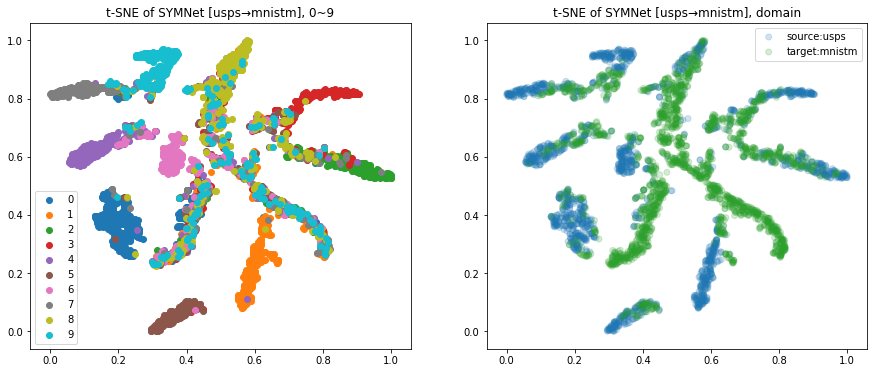

==> creating model 'resnet18' 


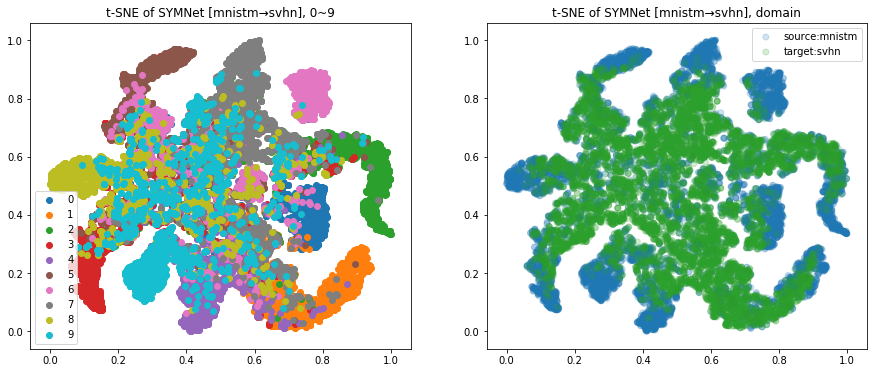

==> creating model 'resnet18' 


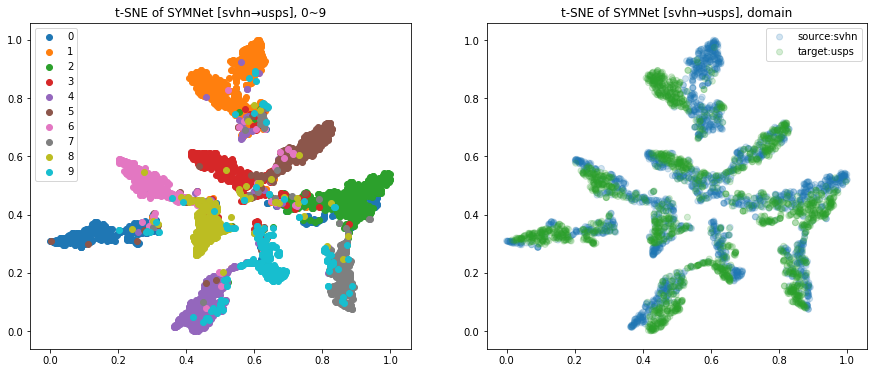

In [5]:
%matplotlib inline

transfers = [('usps','mnistm'), ('mnistm','svhn'), ('svhn','usps')]

for source, target in transfers:
        
    # load dataset & dataloader
    source_dataset = Digits_Dataset(root+f'/{source}/test/', source, trans)
    target_dataset = Digits_Dataset(root+f'/{target}/test/', target, trans)
    source_dataloader = DataLoader(source_dataset,
                                  batch_size=256,
                                  num_workers=6,
                                  collate_fn=source_dataset.collate_fn)
    target_dataloader = DataLoader(target_dataset,
                                  batch_size=256,
                                  num_workers=6,
                                  collate_fn=target_dataset.collate_fn)
        
    # load model
    feature_extractor = load_feature_extractor(args, source, target)
        
    # plot
    plot(feature_extractor, source_dataloader, target_dataloader, source, target)
        
    del feature_extractor
    